Installing the opencs as per the direction from the question pdf

In [14]:
pip install opencv-python numpy


Importing the necessary libraries and loading the grayscale image.


In [92]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Loading of the grayscale image
from google.colab import files
uploaded = files.upload()

Saving 43074.jpg to 43074 (1).jpg


In [93]:
#After uploading, reading the image
img_name = list(uploaded.keys())[0]
I = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)

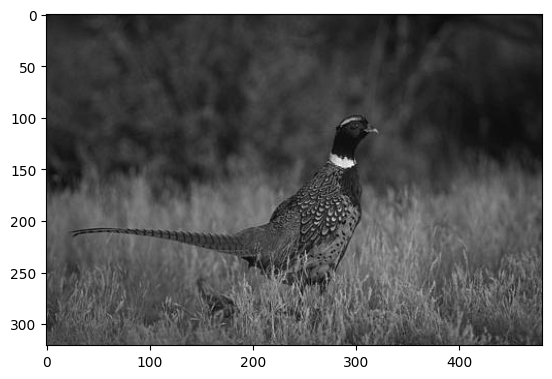

In [94]:
plt.imshow(I, cmap=plt.get_cmap('gray'))
plt.show()

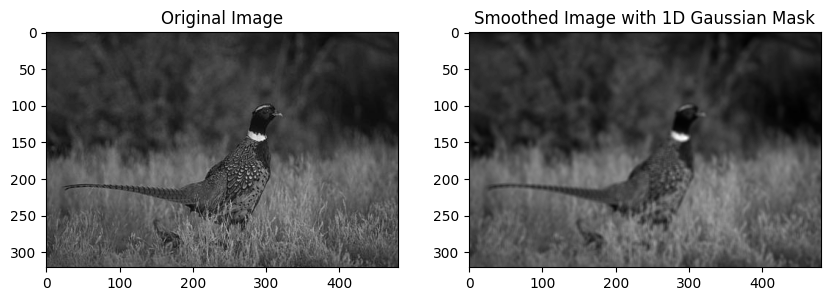

In [108]:


#Function to create a 1D Gaussian Mask
def gaussian_mask_1d(σ, kernel_size):
    # Creating a 1D Gaussian kernel
    kernel = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    gaussian_kernel = np.exp(-0.5 * (kernel / σ)**2)
    gaussian_kernel /= gaussian_kernel.sum()
    return gaussian_kernel

#Function to convolve the image with the Gaussian mask (in both X and Y direction)
def apply_1d_gaussian_smoothing(I, σ, kernel_size):

    G = gaussian_mask_1d(σ, kernel_size)

    # Convolve the image with the 1D Gaussian mask in both directions (X and Y)
    #and Applying Gaussian blur in X and Y direction
    smoothed_x = cv2.filter2D(I, -1, G.reshape(1, -1))
    smoothed_xy = cv2.filter2D(smoothed_x, -1, G.reshape(-1, 1))

    return smoothed_xy

#Parameters for Gaussian Mask.
σ = 3
kernel_size = 5

#Applyung the Gaussian smoothing using 1D Gaussian mask
smoothed_image = apply_1d_gaussian_smoothing(I, σ, kernel_size)

#code for plotting the image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(I, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(smoothed_image, cmap='gray')
plt.title('Smoothed Image with 1D Gaussian Mask')

plt.show()

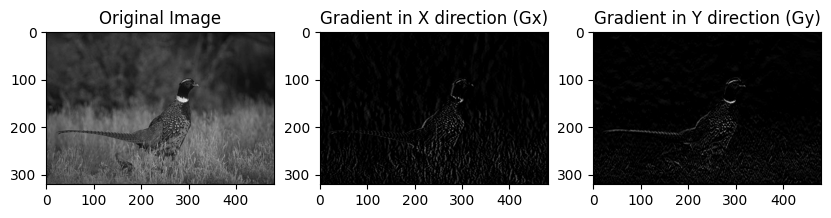

In [109]:
#Function to create the first derivative of a 1D Gaussian mask
def gaussian_derivative_1d(σ, kernel_size):

    kernel = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)

    #Computing the first derivative of the Gaussian
    gaussian_derivative = -kernel * np.exp(-0.5 * (kernel / σ)**2)
    gaussian_derivative /= np.sum(np.abs(gaussian_derivative))
    return gaussian_derivative

#Function to convolve the image with the first derivative of Gaussian (Gx and Gy)
def apply_gaussian_derivative_smoothing(I, σ, kernel_size):
    Gx = gaussian_derivative_1d(σ, kernel_size)
    Gy = Gx.T

    #Convolving the image with Gx and Gy
    gradient_x = cv2.filter2D(I, -1, Gx.reshape(1, -1))
    gradient_y = cv2.filter2D(I, -1, Gy.reshape(-1, 1))

    return gradient_x, gradient_y

#Parameters for Gaussian derivative mask
σ = 3
kernel_size = 5

gradient_x, gradient_y = apply_gaussian_derivative_smoothing(I, σ, kernel_size)

#plotting the image
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(I, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(gradient_x, cmap='gray')
plt.title('Gradient in X direction (Gx)')

plt.subplot(1, 3, 3)
plt.imshow(gradient_y, cmap='gray')
plt.title('Gradient in Y direction (Gy)')

plt.show()

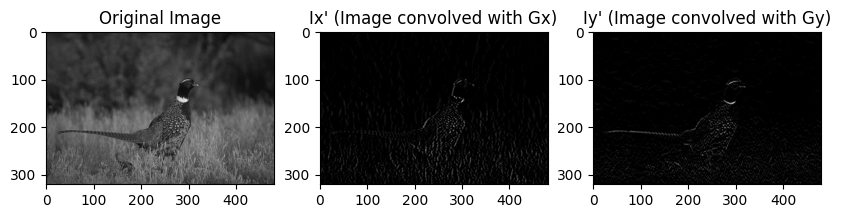

In [110]:
#Convolution of Ix with Gx and Iy with Gy
def convolve_gradients(Ix, Iy, Gx, Gy):
    Ix_prime = cv2.filter2D(Ix, -1, Gx.reshape(1, -1))

    # Convolve Iy with Gy to get Iy'
    Iy_prime = cv2.filter2D(Iy, -1, Gy.reshape(-1, 1))

    return Ix_prime, Iy_prime

Gx = gaussian_derivative_1d(σ, kernel_size)
Gy = Gx.T

# Now, getting the gradients Ix and Iy
Ix, Iy = gradient_x, gradient_y

Ix_prime, Iy_prime = convolve_gradients(Ix, Iy, Gx, Gy)

#plotting the image
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(I, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(Ix_prime, cmap='gray')
plt.title("Ix' (Image convolved with Gx)")

plt.subplot(1, 3, 3)
plt.imshow(Iy_prime, cmap='gray')
plt.title("Iy' (Image convolved with Gy)")

plt.show()


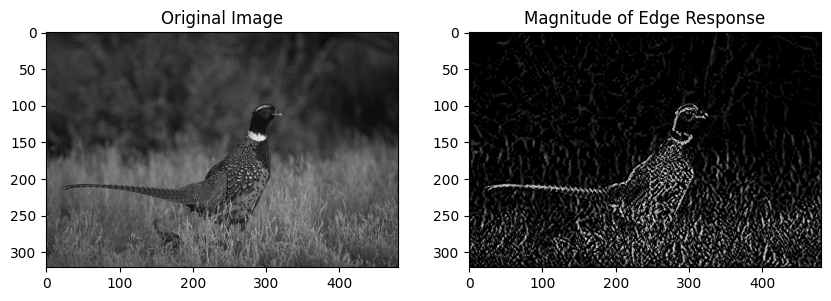

In [111]:
#Function to compute the magnitude of the edge response
def compute_magnitude(Ix_prime, Iy_prime):
    magnitude = np.sqrt(Ix_prime**2 + Iy_prime**2)
    return magnitude

#Computing the magnitude of the edge response
magnitude = compute_magnitude(Ix_prime, Iy_prime)

#plotting the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(I, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(magnitude, cmap='gray')
plt.title('Magnitude of Edge Response')

plt.show()


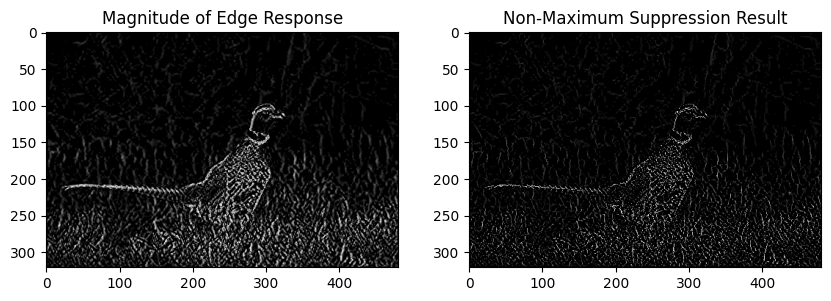

In [112]:
#Function to compute the gradient direction (orientation)
def compute_gradient_direction(Ix_prime, Iy_prime):
    direction = np.arctan2(Iy_prime, Ix_prime)
    direction = np.degrees(direction)
    direction[direction < 0] += 180
    return direction

# no creating the Non-Maximum Suppression Function
def non_maximum_suppression(magnitude, direction):
    #Getting the dimensions of the image
    M, N = magnitude.shape
    suppressed = np.zeros((M, N), dtype=np.float32)

    # Creating a loop iterating over the image
    for i in range(1, M-1):
        for j in range(1, N-1):
            angle = direction[i, j]

            #Determining the two neighboring pixels to compare with based on the direction
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbors = [magnitude[i, j-1], magnitude[i, j+1]]
            elif 22.5 <= angle < 67.5:
                neighbors = [magnitude[i-1, j+1], magnitude[i+1, j-1]]
            elif 67.5 <= angle < 112.5:
                neighbors = [magnitude[i-1, j], magnitude[i+1, j]]
            elif 112.5 <= angle < 157.5:
                neighbors = [magnitude[i-1, j-1], magnitude[i+1, j+1]]

            #Now suppressing the current pixel if it is not a local maximum
            if magnitude[i, j] >= max(neighbors):
                suppressed[i, j] = magnitude[i, j]
            else:
                suppressed[i, j] = 0

    return suppressed

direction = compute_gradient_direction(Ix_prime, Iy_prime)

nms_result = non_maximum_suppression(magnitude, direction)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(magnitude, cmap='gray')
plt.title('Magnitude of Edge Response')

plt.subplot(1, 2, 2)
plt.imshow(nms_result, cmap='gray')
plt.title('Non-Maximum Suppression Result')

plt.show()

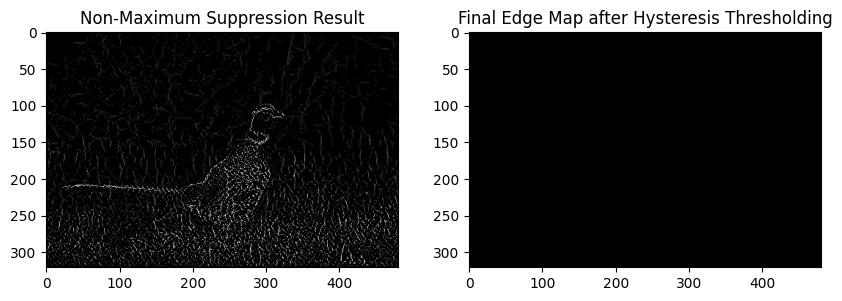

In [113]:


#Hysteresis thresholding function
def hysteresis_thresholding(nms_result, low_threshold, high_threshold):

    edges = cv2.Canny(np.uint8(nms_result), low_threshold, high_threshold)

    return edges

#Setting thresholds
low_threshold = 50
high_threshold = 100

#Applying the Hysteresis Thresholding
final_edges = hysteresis_thresholding(nms_result, low_threshold, high_threshold)

#plotting the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(nms_result, cmap='gray')
plt.title('Non-Maximum Suppression Result')

plt.subplot(1, 2, 2)
plt.imshow(final_edges, cmap='gray')
plt.title('Final Edge Map after Hysteresis Thresholding')

plt.show()
